In [ ]:
# First attempt at running Tractor (https://github.com/dstndstn/tractor) on HSC-wide coadds.
# I ended up implementing this better in an example script which I may send off as a pull request

import configparser
import fitsio
import itertools
import numpy as np
import os
import tractor

import matplotlib.pyplot as plt

from astrometry.util.run_command import run_command

def hsc_readpass(file):
    parser = configparser.ConfigParser(delimiters=[" "])

    with open(file) as text:
        text = itertools.chain(("[top]",), text)
        parser.read_file(text)

    return parser["top"]["User"], parser["top"]["Password"]


# For how to set your login from a file, see:
#   https://serverfault.com/questions/267470/wget-is-there-a-way-to-pass-username-and-password-from-a-file


def hsc_wget(outfile, ra, dec, semiwidth=None, semiheight=None, getpsf=None, imgtype=None, hscfilter=None,
             getimage=None, getmask=None, getvariance=None, rerun=None, curl=None, user=None, password=None):
    if imgtype is None:
        imgtype = "coadd"
    if hscfilter is None:
        hscfilter = "HSC-R"
    if rerun is None:
        rerun = "pdr1_wide"
    if getimage is None:
        getimage = True
    if getmask is None:
        getmask = True
    if getvariance is None:
        getvariance = True
    if curl is None:
        curl = False
    if getpsf is None:
        getpsf = False

    values = {
        "ra": ra
        , "dec": dec
        , "type": imgtype
        , "filter": hscfilter
        , "rerun": rerun
    }

    if not getpsf:
        if semiwidth is None:
            semiwidth = "30asec"
        
        if semiheight is None:
            semiheight = "30asec"
        
        values["sw"] = semiwidth
        values["sh"] = semiheight

        if getimage:
            values["image"] = "on"

        if getmask:
            values["mask"] = "on"

        if getvariance:
            values["variance"] = "on"

    flags = ['{:s}={:s}'.format(key, value) for key, value in values.items()]
    flags = "&".join(flags)

    url = "https://hsc-release.mtk.nao.ac.jp/"

    if getpsf:
        url += "psf/pdr1/cgi/getpsf?"
    else:
        url += "das_quarry/cgi-bin/quarryImage?"\

    url += flags

    cmd = ""
    if curl:
        cmd += "curl -n -o "
    else:
        cmd += "wget --continue -nv -O "

    fmt = "'{:s}' '{:s}'"
    args = [outfile, url]
    if user is not None:
        fmt += " --user '{:s}"
        if not curl:
            fmt += "'"
        args.append(user)
    if password is not None:
        if curl:
            fmt += ":{:s}'"
        else:
            fmt += " --password '{:s}'"
        args.append(password)

    cmd += fmt.format(*args)

    (rtn, out, err) = run_command(cmd)
    if rtn:
        print('Command failed: command', cmd)
        print('Output:', out)
        print('Error:', err)
        print('Return val:', rtn)
        return None

    return rtn



In [261]:
#hscfile = "/home/taranu/.hsc"
#user, password = hsc_readpass(hscfile)
gid = "G63777"
ra = "216.88216861"
dec = "-0.29013127"
semiwidth = "30asec"
semiheight = semiwidth

prefixg = os.path.expanduser("~/raid/hsc/" + gid + "_")
bandshsc = ["HSC-" + band for band in ["G", "R", "I", "Z", "Y"]]

data = {}
extensions = {
    "image": "IMAGE"
    , "mask": "MASK"
    , "variance": "VARIANCE"
}

tims = []
masks = []

'''
        Otherwise, *masks* must be a list, with length equal to the
        number of images.  Each list element must be a dictionary with
        Source objects for keys and ModelMask objects for values.
        Sources that do not touch the image should not exist in the
        dictionary; all the ModelMask objects should be non-None and
        non-empty.
'''



galaxy = tractor.CompositeGalaxy(tractor.PixPos(180., 180.),
    tractor.Fluxes(**dict([(band, 15.) for band in bandshsc])),
    tractor.EllipseE(10., 0., 0.),
    tractor.Fluxes(**dict([(band, 15.) for band in bandshsc])),
    tractor.EllipseE(5., 0., 0.))

for band in bandshsc:
    fitsband = prefixg + "_".join([band, "imgs"]) + ".fits"
    if not os.path.isfile(fitsband):
        rtn = hsc_wget(fitsband, ra, dec, semiwidth=semiwidth, semiheight=semiheight, hscfilter=band)
    
    fitsheader = fitsio.read_header(fitsband)
    fitsobj = fitsio.FITS(fitsband)
    for extension, extensionname in extensions.items():
        if extensionname not in fitsobj:
            raise RuntimeError(
                "Couldn't find {:s} extension='{:s}' in file='{:s}'",
                extension, extensionname, fitsband)  
    
    psfband = prefixg + "_".join([band, "psf"]) + ".fits"
    if not os.path.isfile(psfband):
        rtn = hsc_wget(psfband, ra, dec, getpsf=True, hscfilter=band)
   
    psf = fitsio.read(psfband)
    mask = fitsio.read(fitsband, ext=extensions["mask"])
    cen = [np.int(np.floor(x/2.0)) for x in mask.shape]
    mask = mask == mask[cen[0], cen[1]]
    variance = fitsio.read(fitsband, ext=extensions["variance"])
    
    #wcs = 
    photocal = tractor.LinearPhotoCal(scale=fitsheader["FLUXMAG0"]/1e9)
    image = tractor.Image(
        data=fitsio.read(fitsband, ext=extensions["image"])
        , invvar=1.0/variance
        , inverr=1.0/np.sqrt(variance)
        , psf=psf
        , name='_'.join([gid, "coadd", band])
    )
    tims.append(image)
    masks.append({galaxy: tractor.ModelMask(0, 0, mask)})

/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


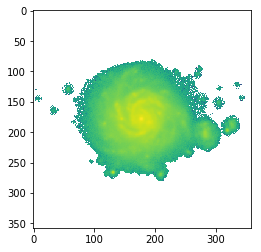

413.3505394345238


In [264]:
mask = masks[0][galaxy]
segment = mask.mask == mask.mask[180, 180]
plt.imshow(np.log10(tims[0].data*segment))
pl.show()

print(np.sum(tims[0].data*segment))

In [234]:
fits = fitsio.FITS(fitsband)
fitsio.read_header(fitsband)["FLUXMAG0"]

63095734448.0194

In [253]:
masks

[{CompositeGalaxy(pos=PixPos[180.0, 180.0], brightnessExp=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeExp=re=10, e1=0, e2=0, brightnessDev=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeDev=re=5, e1=0, e2=0: ModelMask(0,0, mask of shape w=359, h=358)},
 {CompositeGalaxy(pos=PixPos[180.0, 180.0], brightnessExp=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeExp=re=10, e1=0, e2=0, brightnessDev=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeDev=re=5, e1=0, e2=0: ModelMask(0,0, mask of shape w=359, h=358)},
 {CompositeGalaxy(pos=PixPos[180.0, 180.0], brightnessExp=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeExp=re=10, e1=0, e2=0, brightnessDev=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeDev=re=5, e1=0, e2=0: ModelMask(0,0, mask of shape w=359, h=358)},
 {CompositeGalaxy(pos=PixPos[180.0, 180.0], brightnessExp=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeExp=re=10, e1=0, e2=0, brightnessDev=Fluxes[15.0, 15.0, 15.0, 15.0, 15.0], shapeDev=re=5, e1=0, e2=0: ModelMask(0,0, mask of shape w=359, h=358)},
 {Compos

In [263]:
fitsheader["FLUXMAG0"]/1e9

63.0957344480194